In [66]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [67]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL_SIZE = 3
EPOCHS = 50

In [68]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1000 files belonging to 1 classes.


In [69]:
class_names = dataset.class_names
class_names

['Potato___Early_blight']

In [70]:
len(dataset)

32

In [71]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 256, 256, 3)
(32,)


In [72]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[6].numpy())
    print(label_batch[6].numpy())

[[[101.  97. 112.]
  [123. 119. 134.]
  [122. 118. 132.]
  ...
  [173. 171. 184.]
  [153. 151. 164.]
  [175. 173. 186.]]

 [[124. 120. 135.]
  [121. 117. 132.]
  [111. 107. 121.]
  ...
  [152. 150. 163.]
  [175. 173. 186.]
  [162. 160. 173.]]

 [[134. 130. 145.]
  [113. 109. 124.]
  [106. 102. 116.]
  ...
  [196. 194. 207.]
  [192. 190. 203.]
  [158. 156. 169.]]

 ...

 [[130. 128. 142.]
  [118. 116. 130.]
  [132. 130. 144.]
  ...
  [198. 201. 210.]
  [168. 171. 180.]
  [187. 190. 199.]]

 [[149. 147. 161.]
  [153. 151. 165.]
  [143. 141. 155.]
  ...
  [183. 186. 195.]
  [171. 174. 183.]
  [194. 197. 206.]]

 [[120. 118. 132.]
  [129. 127. 141.]
  [ 96.  94. 108.]
  ...
  [172. 175. 184.]
  [168. 171. 180.]
  [179. 182. 191.]]]
0


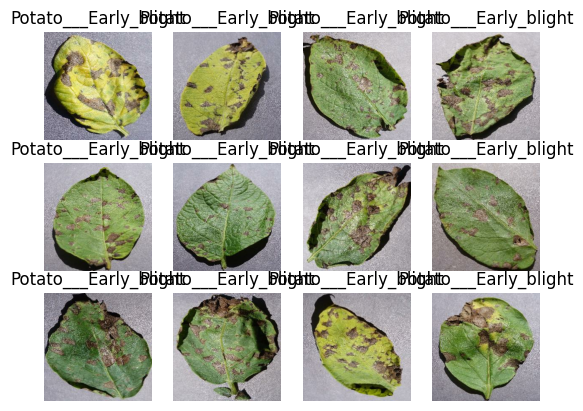

In [73]:
for image_batch, label_batch in dataset.take(1): # take first batch
    for i in range(12): # twelves images from first batch
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [74]:
train_size = 0.8
test_size = 0.1
val_size = 0.1

print(len(dataset)*train_size)
print(len(dataset)*test_size)
print(len(dataset)*val_size) # validation is from test

25.6
3.2
3.2


In [75]:
train_ds = dataset.take(516)
test_ds = dataset.skip(516)

val_ds = test_ds.take(64)
test_ds = test_ds.skip(64)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

32
0
0


In [76]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
#     test_size = int(ds_size * test_split) Either val_size and test_size is the same
    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    
    val_ds = test_ds.take(val_size)
    test_ds = test_ds.skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [77]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

25
3
4


In [78]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [79]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [80]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.Rescaling(0.2)
])

In [81]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_SIZE)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [82]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_13 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_33 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [83]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [86]:
history = model.fit(
    train_ds,
    epochs=3,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/3
25/25 [==============================] - 18s 737ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
25/25 [==============================] - 18s 731ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
25/25 [==============================] - 19s 751ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (3,)

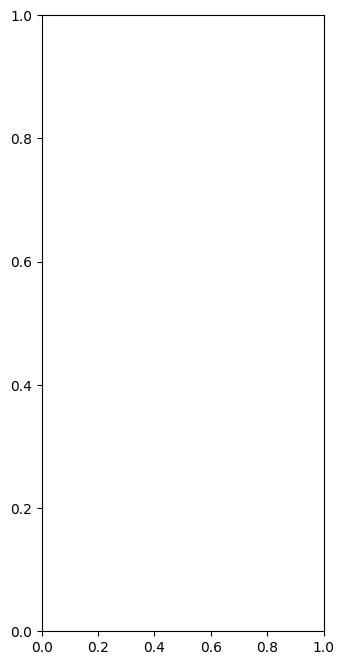

In [88]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images.batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[firstlabel])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])

In [103]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    batch_predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(batch_predictions[0])]
    confidence = round(100 * (np.max(batch_predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


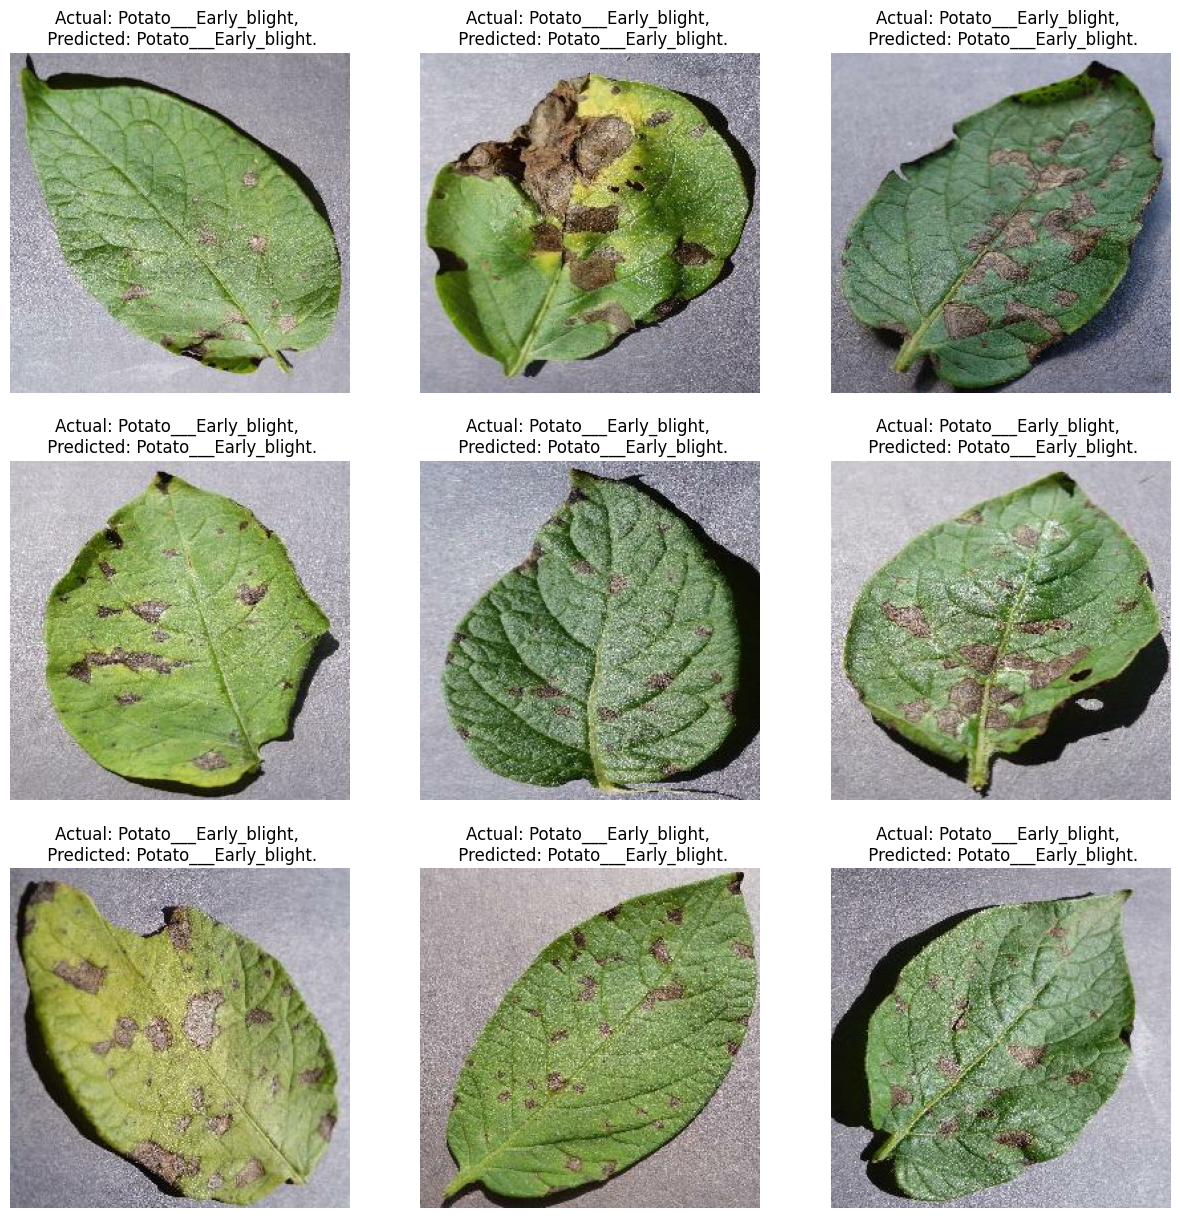

In [109]:
import numpy as np
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")

In [110]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
